In [20]:
import os

import pandas as pd
from torch import nn, optim, device, cuda
import torch

import yaml
from tqdm import tqdm, trange

import wandb

from data_parser import adj_matrix, nodes
from image_parser import train_loader, test_loader, debug_loader
from utils import log_training_images

from models import CombinedModel
from model_config_manager import ModelConfigManager

In [2]:
config = yaml.safe_load(open("config.yml"))
DEBUG = config["DEBUG"]
epochs = config["EPOCHS"] if not DEBUG else 2
RETINA_MODEL = config["RETINA_MODEL"]
images_fraction = config["IMAGES_FRACTION"]
continue_training = config["CONTINUE_TRAINING"]
saved_model_path = config["SAVED_MODEL_PATH"]

loader = debug_loader if DEBUG else train_loader

dev = device("cuda" if cuda.is_available() else "cpu")    

# Create the ModelConfigManager and load configurations from YAML files
config_manager = ModelConfigManager()

# Get a specific configuration by model name
config_manager.set_model_config(RETINA_MODEL)

wandb: Currently logged in as: eudald. Use `wandb login --relogin` to force relogin


In [10]:
combined_model = CombinedModel(adj_matrix, neurons=nodes, model_config=config_manager.model_config)

if continue_training:
    # If we want to continue training a saved model
    combined_model.load_state_dict(torch.load(saved_model_path))

combined_model = combined_model.to(dev)
wandb.init(project="connectome", config=config_manager.model_config)

# Specify the loss function and the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.00001)
_ = wandb.watch(combined_model, criterion, log="all") 


In [11]:
config_manager.output_model_details()
if DEBUG:
    print("WARNING: Running on DEBUG mode, so using 10% of the images")
elif images_fraction < 1:
    print(f"WARNING: Using {images_fraction * 100}% of the images")

for epoch in trange(epochs):
    running_loss = 0
    correct_predictions = 0
    # If the model is fast~ish
    # for images, labels in train_loader:
    j = 0
    for images, labels in tqdm(loader):
        # print(f"Image {j}")
        # Move images and labels to the device
        images, labels = images.to(dev), labels.to(dev)

        # Checks
        if torch.isnan(images).any():
            raise Exception("NaN in images")
        if torch.isnan(labels).any():
            raise Exception("NaN in labels")

        # Forward pass
        outputs = combined_model(images)

        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Compute the accuracy
        predicted_labels = torch.argmax(outputs, dim=1)
        correct_predictions = (predicted_labels == labels).sum().item()
        accuracy = correct_predictions / len(labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Logs to wandb
        wandb.log({"loss": loss.item(), "accuracy": accuracy, "epoch": epoch})
        log_training_images(images, labels, outputs)
            
        j += 1

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')
    # Save model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save(combined_model.state_dict(), os.path.join("models", f"model_{RETINA_MODEL}_{epoch + 1}_epochs.pth"))
        print(f"Saved model after {epoch + 1} runs")

wandb.finish()

Model configurations:
Model name: cnn_2_1
Number of layers: 2
Output channels: 2
Kernel size: 5
Stride: 2
Padding: 1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/680 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1207.5845233692842


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:08.000837, resuming normal operation.


Epoch 2/20, Loss: 788.4314594246886
Saved model after 2 runs


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:08.027798, resuming normal operation.
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: Network error resolved after 0:00:07.890904, resuming normal operation.
wandb: Network er

Epoch 3/20, Loss: 823.3480124082197


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:08.209567, resuming normal operation.
wandb: Network error resolved after 0:00:07.780124, resuming normal operation.


Epoch 4/20, Loss: 480.7696731567383
Saved model after 4 runs


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:07.784076, resuming normal operation.
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: Network error 

Epoch 5/20, Loss: 614.5704825435045


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:03.972159, resuming normal operation.


Epoch 6/20, Loss: 602.7970261519446
Saved model after 6 runs


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:08.195919, resuming normal operation.
wandb: Network error resolved after 0:00:08.115586, resuming normal operation.


Epoch 7/20, Loss: 432.1612542993882


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:00.137048, resuming normal operation.
wandb: Network error resolved after 0:00:08.043416, resuming normal operation.


Epoch 8/20, Loss: 360.44047098237803
Saved model after 8 runs


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:08.027213, resuming normal operation.


Epoch 9/20, Loss: 349.4517018486691


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:07.872692, resuming normal operation.
wandb: Network error resolved after 0:00:07.816878, resuming normal operation.


Epoch 10/20, Loss: 352.0094336625408
Saved model after 10 runs


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:07.733437, resuming normal operation.
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: Network error resolved after 0:00:07.804408, resuming normal operation.


Epoch 11/20, Loss: 332.2055417900517


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({

Epoch 12/20, Loss: 226.89943365463438
Saved model after 12 runs


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:01.342366, resuming normal operation.
wandb: Network error resolved after 0:00:07.955570, resuming normal operation.


Epoch 13/20, Loss: 236.85898087445426


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:08.172702, resuming normal operation.


Epoch 14/20, Loss: 216.98507223690257
Saved model after 14 runs


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:07.722211, resuming normal operation.
wandb: Network error resolved after 0:00:08.185832, resuming normal operation.


Epoch 15/20, Loss: 189.64170676469803


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:07.744706, resuming normal operation.


Epoch 16/20, Loss: 188.68498318427626
Saved model after 16 runs


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:08.085127, resuming normal operation.


Epoch 17/20, Loss: 226.67889871036306


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:00.173962, resuming normal operation.
wandb: Network error resolved after 0:00:00.188142, resuming normal operation.
wandb: Network error resolved after 0:00:07.874750, resuming normal operation.


Epoch 18/20, Loss: 199.85327175364776
Saved model after 18 runs


  0%|          | 0/680 [00:00<?, ?it/s]

Epoch 19/20, Loss: 181.04788121606688


  0%|          | 0/680 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:03.457115, resuming normal operation.
wandb: Network error resolved after 0:00:07.980932, resuming normal operation.


Epoch 20/20, Loss: 143.6150112455382
Saved model after 20 runs


accuracy,▁█▅▅▅▅█▅█▅▅▁▅▁███▁██▅▅██▅██▅███▅████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
loss,▆▁▁▂▂▆▁▁▁▂▂▃▄█▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
accuracy,0.875
epoch,19
loss,99.60938


In [9]:
# torch.save(combined_model.state_dict(), os.path.join("models", f"model_{RETINA_MODEL}_{epoch + 1}_epochs.pth"))

In [57]:
# Test de model
correct = 0
total = 0
test_results_df = pd.DataFrame(columns=["Image", "Real Label", "Predicted Label", "Correct Prediction"])

j = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(dev), labels.to(dev)
        outputs = combined_model(images)
        _, predicted = torch.max(outputs.data, 1)
        # Convert the tensor values to CPU and numpy
        labels_cpu = labels.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()
        
        # Check if the prediction is correct
        correct_predictions = (predicted == labels)
        correct_cpu = correct_predictions.cpu().numpy()
        
        image_names = [a[0] for a in test_loader.dataset.dataset.samples[j * test_loader.batch_size: (j + 1) * test_loader.batch_size]]
        j += 1
        
        batch_df = pd.DataFrame({
            "Image": image_names,
            "Real Label": labels_cpu,
            "Predicted Label": predicted_cpu,
            "Correct Prediction": correct_cpu.astype(int)
        })
        
        # Append the batch DataFrame to the list
        test_results_df = pd.concat([test_results_df, batch_df], ignore_index=True)

100%|██████████| 170/170 [00:08<00:00, 19.18it/s]


In [22]:
print(f"Accuracy on the {total} test images: {100 * correct / total}%")

Accuracy on the 0 test images: inf%


C:\Users\eudald\AppData\Local\Temp\ipykernel_18200\1033465022.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Accuracy on the {total} test images: {100 * correct / total}%")


In [59]:
# Assuming you have a DataFrame named 'test_results_df' with a 'image_filename' column
test_results_df['yellow'] = test_results_df['Image'].apply(lambda x: x.split('_')[1])
test_results_df['blue'] = test_results_df['Image'].apply(lambda x: x.split('_')[2])
test_results_df['weber_ratio'] = test_results_df.apply(lambda row: max(int(row['yellow']), int(row['blue'])) / min(int(row['yellow']), int(row['blue'])), axis=1)

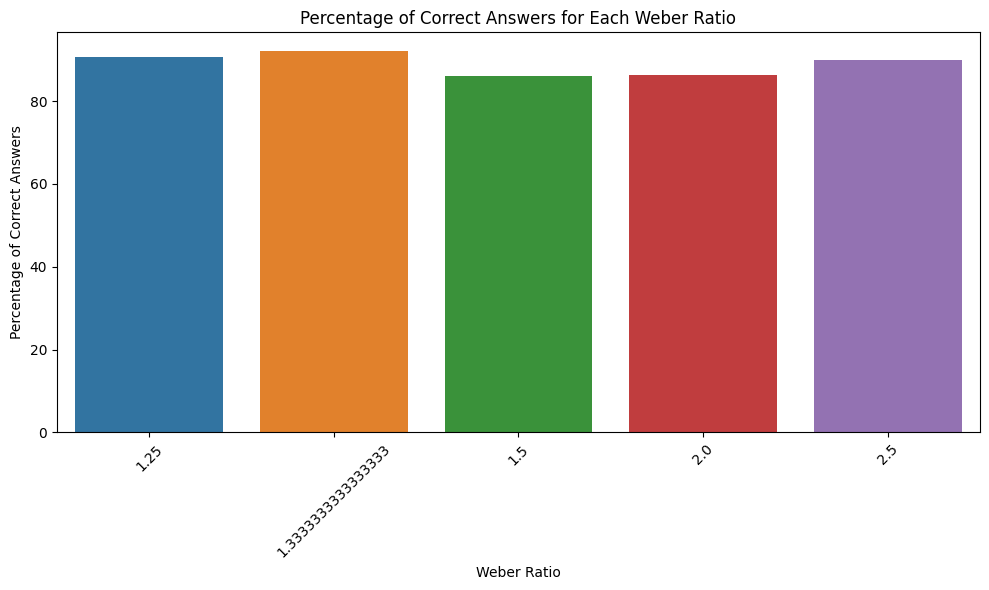

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage of correct answers for each Weber ratio
correct_percentage = test_results_df.groupby('weber_ratio')['Correct Prediction'].mean() * 100

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correct_percentage.index, y=correct_percentage.values)
plt.xlabel('Weber Ratio')
plt.ylabel('Percentage of Correct Answers')
plt.title('Percentage of Correct Answers for Each Weber Ratio')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
# Test de model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(dev), labels.to(dev)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

  0%|          | 0/170 [00:00<?, ?it/s]

In [17]:
print(f"Accuracy on the {total} test images: {100 * correct / total}%")

Accuracy on the 1360 test images: 53.602943420410156%
